In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.fft import rfft,rfftfreq,irfft
import requests

sns.set()

In [3]:
url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101G/ManadFoddDod'
json_post = {
  "query": [
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Manad",
      "selection": {
        "filter": "item",
        "values": [
          "01",
          "02",
          "03",
          "04",
          "05",
          "06",
          "07",
          "08",
          "09",
          "10",
          "11",
          "12"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "000000NF"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [4]:
r = requests.post(url,json = json_post)
r.status_code

200

In [5]:
json = r.json()
data = json['data']

In [6]:
dead_df = pd.DataFrame.from_dict(data)
dead_df

,key,values
0,"[1, 01, 1851]",[3245]
1,"[1, 01, 1852]",[3403]
2,"[1, 01, 1853]",[3559]
3,"[1, 01, 1854]",[2980]
4,"[1, 01, 1855]",[3244]
...,...,...
4075,"[2, 12, 2016]",[4379]
4076,"[2, 12, 2017]",[4228]
4077,"[2, 12, 2018]",[4091]
4078,"[2, 12, 2019]",[3997]


In [7]:
dead_df[['gender','month','year']] = dead_df['key'].to_list()
dead_df['dead'] = dead_df['values'].apply(lambda x : x[0])
dead_df.drop(['key','values'],axis=1,inplace=True)
dead_df['dead'] = dead_df['dead'].astype(int)
dead_df = dead_df.groupby(['year','month']).sum()
dead_df

dead
year month       
1851 01      6261
     02      6007
     03      8812
     04      7818
     05      7406
...           ...
2020 08      6968
     09      6772
     10      7281
     11      8220
     12     10187

[2040 rows x 1 columns]

In [8]:
dead_df = dead_df.loc['2015':]
dead_df

dead
year month       
2015 01      8665
     02      8092
     03      8666
     04      7731
     05      7351
...           ...
2020 08      6968
     09      6772
     10      7281
     11      8220
     12     10187

[72 rows x 1 columns]

In [9]:
# deaths with unknown date not included # 
dead_df.groupby('year').sum()
start_year = dead_df.index[0][0]
end_year = dead_df.index[-1][0]
end_year

'2020'

/usr/local/lib64/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


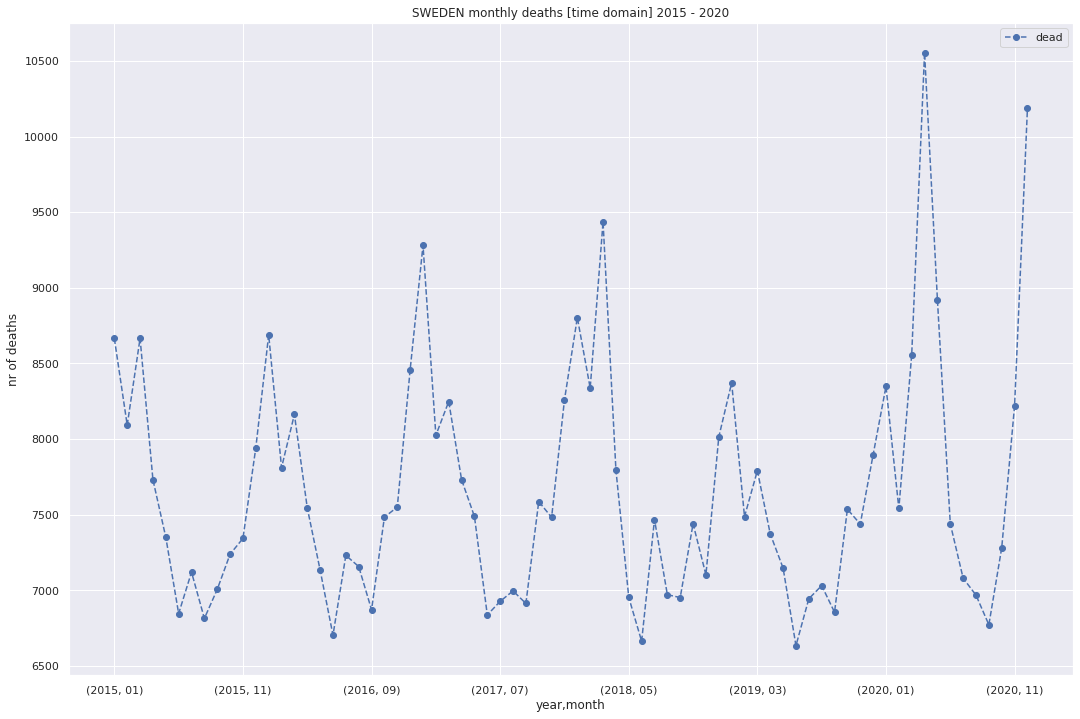

In [10]:
title = 'SWEDEN monthly deaths [time domain] {} - {}'.format(start_year,end_year)
dead_df.plot(figsize=(18,12),style='o--',title=title)
plt.ylabel('nr of deaths')
plt.savefig('swe_fft_time_domain_deaths_{}_{}.jpg'.format(start_year,end_year),format='jpg')

In [38]:
raveled_deaths = pd.Series(dead_df.unstack().values.ravel(),index=pd.date_range('2015-01-01','2020-12-31',freq='M'))
raveled_deaths

2015-01-31     8665
2015-02-28     8092
2015-03-31     8666
2015-04-30     7731
2015-05-31     7351
              ...  
2020-08-31     6968
2020-09-30     6772
2020-10-31     7281
2020-11-30     8220
2020-12-31    10187
Freq: M, Length: 72, dtype: int64

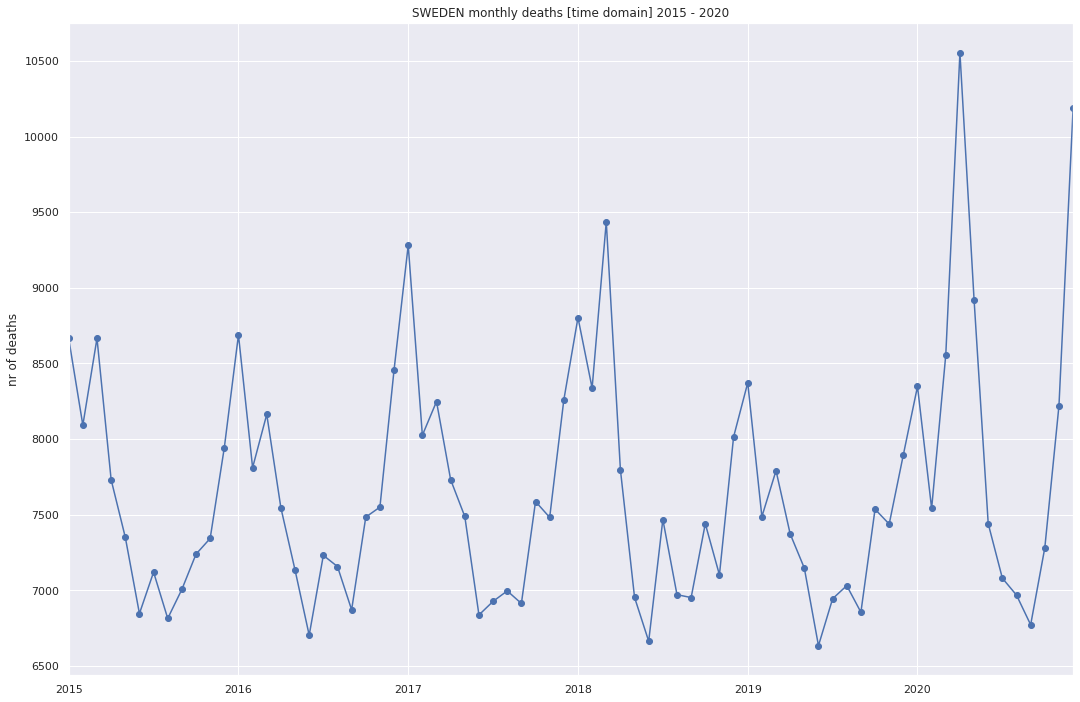

In [42]:
title = 'SWEDEN monthly deaths [time domain] {} - {}'.format(start_year,end_year)

raveled_deaths.plot(figsize=(18,12),marker='o',title=title)
plt.ylabel('nr of deaths')
plt.savefig('swe_fft_time_domain_deaths_{}_{}.jpg'.format(start_year,end_year),format='jpg')

In [11]:
sample_rate = 12 # monthly data : set unit a year

signal = dead_df['dead']
signal = signal - signal.mean()
signal = signal.values

yf = rfft(signal) 

xf = rfftfreq(len(signal),1 / sample_rate)


6


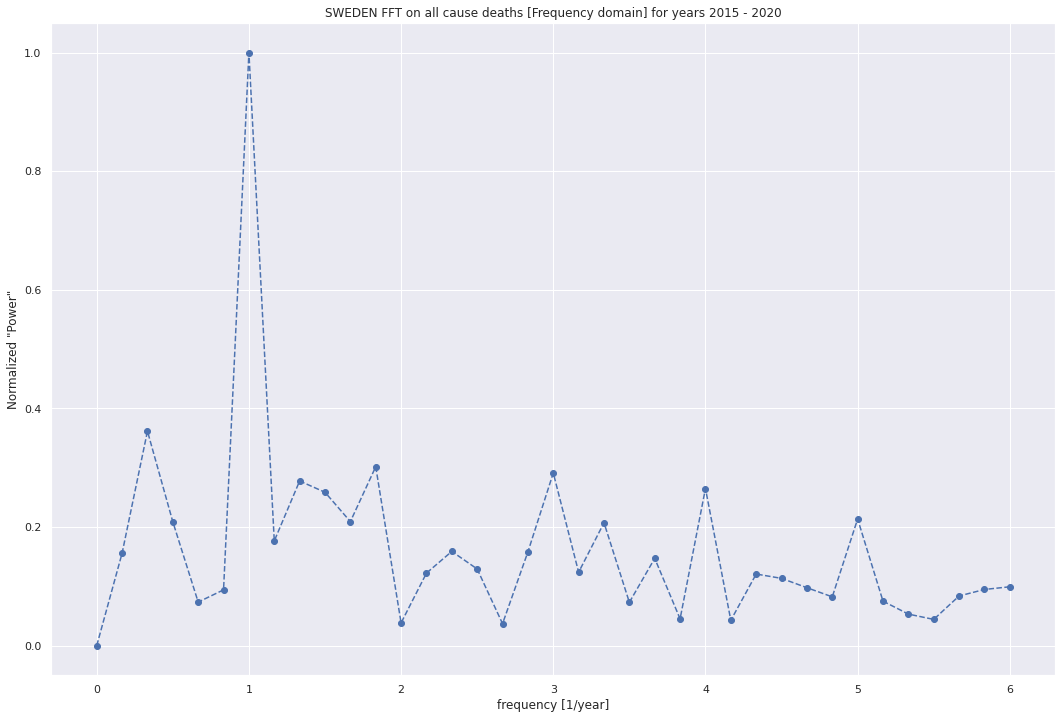

In [16]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN FFT on all cause deaths [Frequency domain] for years {} - {}'.format(start_year,end_year))
plt.xlabel('frequency [1/year]')
plt.ylabel('Normalized "Power"')
plt.plot(xf,np.abs(yf) / np.abs(yf).max(),'o--')
yf_max = yf.argmax()
print (yf_max)
plt.savefig('fft_swe_deaths_periodicity_{}_{}.jpg'.format(start_year,end_year),format='jpg')

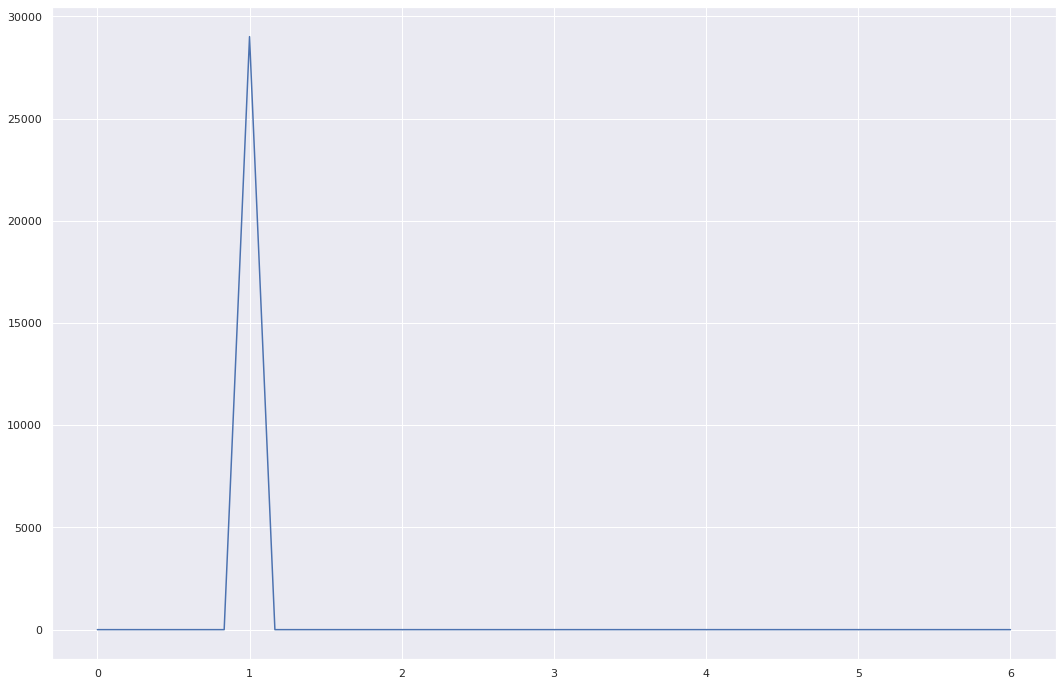

In [13]:
dominant_freq = np.zeros_like(yf)
dominant_freq[yf_max] = yf[yf_max]

plt.figure(figsize=(18,12))
plt.plot(xf,np.abs(dominant_freq))

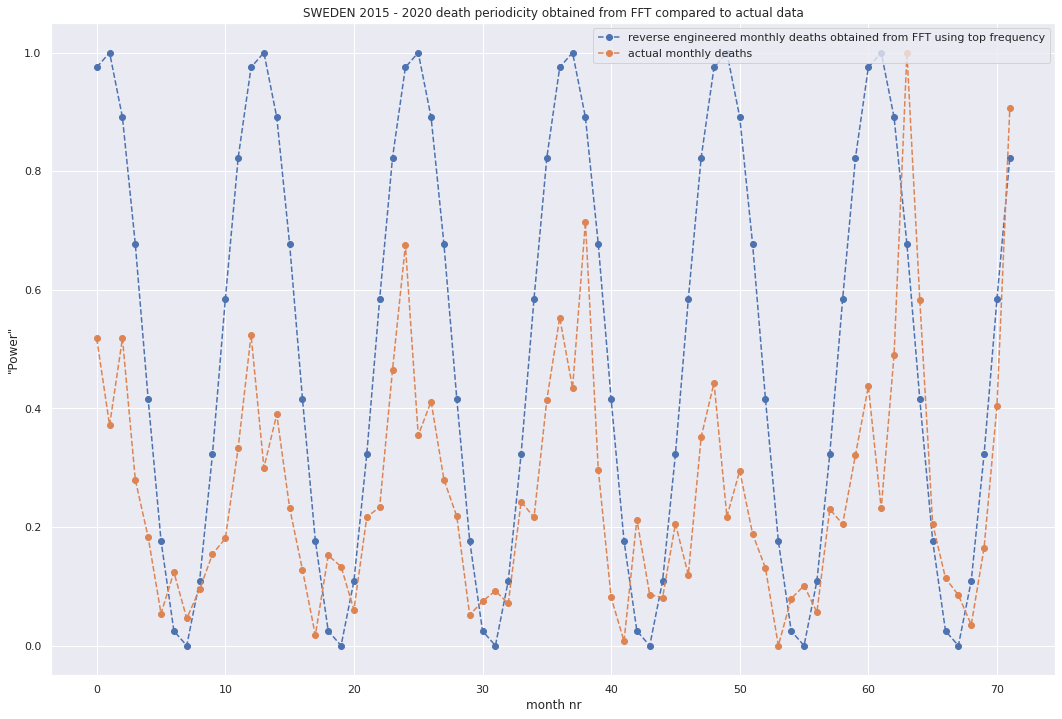

In [14]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

yf_filtered = irfft(dominant_freq)


plt.figure(figsize=(18,12))

ax = plt.gca()

title = 'SWEDEN {} - {} death periodicity obtained from FFT compared to actual data'.format(start_year,end_year)

ax.set_title(title)
ax.plot((yf_filtered / yf_filtered.max() + 1) / (yf_filtered / yf_filtered.max() +1).max(),'o--',
        label='reverse engineered monthly deaths obtained from FFT using top frequency')

ax.plot(NormalizeData(dead_df['dead'].values),'o--',label='actual monthly deaths')

ax.set_xlabel('month nr')
ax.set_ylabel('"Power"')

ax.legend(loc='upper right')
#ax.set_xticklabels(range(1,len(dead_df) + 1),rotation=90)


#for label in ax.xaxis.get_ticklabels()[0::12]:
        #label.set_visible(False)

/usr/local/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


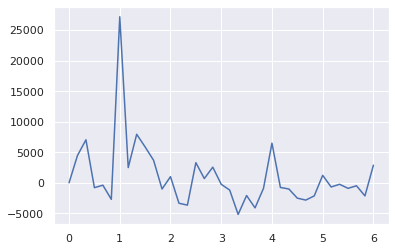

In [15]:
plt.plot(xf,yf)